# Data Analysis

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import math as math
import numpy as np
import re
import plotly.express as px

In [126]:
DIR_DATA_ANIMATIONS = '../data/animations/'

## 1. Clean and Prepare Data

### 1.1. Data Overview

In [2]:
df = pd.read_csv('../data/albert_heijn/ah_data.csv')
df_original = df.copy() # keep copy of original dataframe
print('Number of rows before data cleaning: ' + str(len(df)))

Number of rows before data cleaning: 17072


In [3]:
df.head()

,product,url,category,price,amount,content,unit,vegan,vegetarian,nutriscore,carbs_100g,protein_100g,fat_100g,alcohol_100g
0,De Zaanse Hoeve Roomboter ongezouten,https://www.ah.nl/producten/product/wi429615/d...,ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60,2.49,250.0,Inhoud en gewicht250 GramPortiegrootte: 5 gram...,g,False,True,E,1.0,0.6,82.0,NaN
1,AH Halvarine lekker op brood,https://www.ah.nl/producten/product/wi127489/a...,ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60,1.09,500.0,Inhoud en gewicht500 GramPortiegrootte: 5 gram...,g,True,True,C,0.6,0.0,39.0,NaN
2,AH Zuivelspread naturel,https://www.ah.nl/producten/product/wi506228/a...,ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60,0.79,200.0,Inhoud en gewicht200 GramPortiegrootte: 15 gra...,g,False,True,D,3.3,7.8,16.0,NaN
3,AH Luchtige cracker volkoren met rijstbloem,https://www.ah.nl/producten/product/wi196377/a...,ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60,0.99,250.0,"Inhoud en gewicht250 GramPortiegrootte: 7,5 gr...",g,True,True,A,63.0,10.0,3.6,NaN
4,AH Smeerkaas naturel,https://www.ah.nl/producten/product/wi249/ah-s...,ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60,0.79,100.0,Inhoud en gewicht100 GramPortiegrootte: 15 gra...,g,False,False,D,2.4,14.0,21.0,NaN


In [4]:
# Number of NAs per field:
df.isna().sum()

product             0
url                 0
category            0
price               7
amount           1489
content           441
unit             1489
vegan               0
vegetarian          0
nutriscore       9364
carbs_100g        932
protein_100g      934
fat_100g          953
alcohol_100g    16948
dtype: int64

In [5]:
# Number of Products per Category
df.groupby(["category"])["product"].count()

category
aardappel-groente-fruit?minPrice=0&maxPrice=2.99             874
aardappel-groente-fruit?minPrice=3&maxPrice=99               316
bakkerij-en-banket                                           981
diepvries                                                    861
kaas-vleeswaren-tapas?minPrice=0&maxPrice=2.99               849
kaas-vleeswaren-tapas?minPrice=3&maxPrice=99                 627
ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60              886
ontbijtgranen-en-beleg?minPrice=2.61&maxPrice=99             966
pasta-rijst-en-wereldkeuken?minPrice=0&maxPrice=1.99         796
pasta-rijst-en-wereldkeuken?minPrice=2&maxPrice=3.99         993
pasta-rijst-en-wereldkeuken?minPrice=4&maxPrice=99           233
salades-pizza-maaltijden                                     655
snoep-koek-chips-en-chocolade?minPrice=0&maxPrice=1.89       926
snoep-koek-chips-en-chocolade?minPrice=1.90&maxPrice=2.59    940
snoep-koek-chips-en-chocolade?minPrice=2.60&maxPrice=99      876
soepen-sauzen-kr

### 1.2 Remove Duplicate Products

In [6]:
print('Number of rows before deleting duplicates: ' + str(len(df)))
df = df.drop_duplicates('url', keep='last')
print('Number of rows after deleting duplicates: ' + str(len(df)))

Number of rows before deleting duplicates: 17072
Number of rows after deleting duplicates: 11852


### 1.3. Estimate amount for missing or inexact amount values based on 'content' label

In [7]:
def get_content_amount(content):
    if str(content) == "nan":
        amount = np.NaN
        content_type = "1: Content = NaN"
    else:
        content = content.lower()
        if re.search('gewicht[\d]* gram',content) and content.lower().find('liter')==-1:
            # get total amount label ('gewicht'). Does not work for liquids (ml or liters)
            amount = re.search('gewicht[\d]* gram',content)[0]
            amount = amount.rstrip(' gram').strip('gewicht').replace(',','.')
            amount = float(amount)
            content_type = "2: Total weight in g"
        elif re.search('portiegrootte: [\d\,]* gram',content) and re.search('antal porties: [\d\,]*',content):
            # get portion size and nr of portions
            portion_size = re.search('portiegrootte: [\d\,]* gram',content)[0]
            portion_size = portion_size.rstrip(' gram').strip('portiegrootte: ').replace(',','.')
            portion_size = float(portion_size)
            number_of_portions = re.search('antal porties: [\d\,]*',content)[0]
            number_of_portions = number_of_portions.strip('antal porties: ')
            number_of_portions = float(number_of_portions)
            amount = portion_size * number_of_portions
            content_type = "3: portion_size * number_of_portions"
        else:
            amount = np.NaN
            content_type = "4: NaN (Unknown content format)"
    return amount, content_type

In [8]:
def amount_not_exact(amount):
    if str(amount) == 'nan':
        not_exact = True
    elif amount > 6.5 and amount - math.floor(amount)>0:
        # if number has decimals then amount value was not accurate enough
        # add 6.5 limit to exclude small products like spices
        not_exact = True
    else:
        not_exact = False
    return not_exact

In [9]:
# Estimate amounts based on label
df['amount_old'] = df['amount'] # create copy of amount column
df['amount_content'] = df['content'].apply(lambda x: get_content_amount(x)[0])
df['content_type'] = df['content'].apply(lambda x: get_content_amount(x)[1])
print("Types of 'Content' for Products with no Amount:")
df[df['unit'].isna()].groupby(["content_type"]).count()["product"]
# We are able to estimate more than 50% of missing amounts using the content label (types 2 and 3)

Types of 'Content' for Products with no Amount:


content_type
1: Content = NaN                        276
2: Total weight in g                    370
3: portion_size * number_of_portions    142
4: NaN (Unknown content format)         253
Name: product, dtype: int64

In [10]:
print('Number of products with inexact amounts (either missing or poorly estimated):')
print(sum([amount_not_exact(x) for x in df['amount']]))

Number of products with inexact amounts (either missing or poorly estimated):
1365


In [11]:
# Change amounts that are not exact AND have a valid estimate from the 'content' label
amounts_to_change = [amount_not_exact(x) for x in df['amount']] & df['amount_content'].notna()
print("Amounts before being changed:")
df[amounts_to_change]['amount']

Amounts before being changed:


21       132.352941
427             NaN
918      121.111111
924      121.428571
943             NaN
            ...    
17067           NaN
17068           NaN
17069           NaN
17070           NaN
17071           NaN
Name: amount, Length: 679, dtype: float64

In [12]:
df.loc[amounts_to_change, 'amount'] = df[amounts_to_change]['amount_content'] # Update amounts
df.loc[amounts_to_change, 'unit'] = 'g' # Update unit

In [13]:
print("Amounts after being changed:")
df[amounts_to_change]['amount']
# amount now have the exact values

Amounts after being changed:


21        130.0
427       200.0
918       120.0
924       120.0
943       100.0
          ...  
17067     146.0
17068     202.0
17069     182.0
17070     212.0
17071    1030.0
Name: amount, Length: 679, dtype: float64

In [14]:
print("Number of products which still have missing amounts (these will have to be deleted):")
print(sum(df['unit'].isna()))

Number of products which still have missing amounts (these will have to be deleted):
529


### 1.4 Remove/Update NAs

In [15]:
# Drop records where amount could not be estimated
df = df.dropna(subset=['unit'])
print('Number of rows before data cleaning: ' + str(len(df)))

Number of rows before data cleaning: 11323


In [16]:
print('Number of products with inexact amounts:')
print(sum([amount_not_exact(x) for x in df['amount']]))

Number of products with inexact amounts:
158


In [17]:
# Round remaining inexact amounts. In most cases this results in the correct amount:
df.loc[[amount_not_exact(x) for x in df['amount']], 'amount'] = [round(x) for x in df[[amount_not_exact(x) for x in df['amount']]]['amount']]

In [18]:
print('Number of products with inexact amounts:')
print(sum([amount_not_exact(x) for x in df['amount']]))

Number of products with inexact amounts:
0


In [19]:
# Fill NAs of numeric columns with zero
df['carbs_100g'] = df['carbs_100g'].fillna(0)
df['protein_100g'] = df['protein_100g'].fillna(0)
df['fat_100g'] = df['fat_100g'].fillna(0)
df['alcohol_100g'] = df['alcohol_100g'].fillna(0)

### 1.5 Add New Fields

In [20]:
# Calculate calories: 4 kcal per g of protein/carbs, 7 kcal per g of alcohol, 9 kcal per g of fat
df['calories_100g'] = df.apply(lambda x: x['carbs_100g'] * 4 + x['protein_100g'] * 4 + x['fat_100g'] * 9 + x['alcohol_100g'] * 7, axis = 1)

In [21]:
# Add total amount of macros
df['calories'] = df['calories_100g']*df['amount']/100
df['protein'] = df['protein_100g']*df['amount']/100
df['carbs'] = df['carbs_100g']*df['amount']/100
df['fat'] = df['fat_100g']*df['amount']/100
df['alcohol'] = df['alcohol_100g']*df['amount']/100

In [22]:
df

,product,url,category,price,amount,content,unit,vegan,vegetarian,nutriscore,...,alcohol_100g,amount_old,amount_content,content_type,calories_100g,calories,protein,carbs,fat,alcohol
5,AH Volkoren havermout,https://www.ah.nl/producten/product/wi48405/ah...,ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60,0.69,500.0,Inhoud en gewicht500 GramPortiegrootte: 40 gra...,g,False,False,NaN,...,0.0,500.000000,500.0,2: Total weight in g,355.0,1775.000,70.000,295.00,35.00,0.0
6,AH Beschuit volkoren,https://www.ah.nl/producten/product/wi1625/ah-...,ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60,0.49,140.0,Inhoud en gewicht140 GramPortiegrootte: 11 gra...,g,False,True,A,...,0.0,140.000000,140.0,2: Total weight in g,380.6,532.840,21.000,95.20,7.56,0.0
21,AH Beschuit naturel,https://www.ah.nl/producten/product/wi1624/ah-...,ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60,0.45,130.0,Inhoud en gewicht130 GramPortiegrootte: 10 gra...,g,False,True,A,...,0.0,132.352941,130.0,2: Total weight in g,410.8,534.040,19.500,98.80,6.76,0.0
24,AH Honing,https://www.ah.nl/producten/product/wi479788/a...,ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60,1.99,350.0,Inhoud en gewicht350 GramPortiegrootte: 15 gra...,g,False,True,D,...,0.0,350.000000,350.0,2: Total weight in g,325.6,1139.600,1.400,283.50,0.00,0.0
34,Brinta Volkoren graanontbijt,https://www.ah.nl/producten/product/wi166916/b...,ontbijtgranen-en-beleg?minPrice=0&maxPrice=2.60,2.09,500.0,Inhoud en gewicht500 GramAantal porties: 14,g,False,False,NaN,...,0.0,500.000000,500.0,2: Total weight in g,329.1,1645.500,70.000,320.00,9.50,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17067,SUNT Donut lemon poppyseed,https://www.ah.nl/producten/product/wi537024/s...,bakkerij-en-banket,2.99,146.0,Inhoud en gewicht146 GramPortiegrootte: portie,g,False,False,NaN,...,0.0,NaN,146.0,2: Total weight in g,332.0,484.720,5.110,70.08,20.44,0.0
17068,AH Karamel zeezout cheesecake,https://www.ah.nl/producten/product/wi537027/a...,bakkerij-en-banket,4.00,202.0,Inhoud en gewicht2 StuksPortiegrootte: 101 gra...,g,False,True,E,...,0.0,NaN,202.0,3: portion_size * number_of_portions,337.6,681.952,9.898,78.78,36.36,0.0
17069,AH Cookie & cream slofjes,https://www.ah.nl/producten/product/wi537030/a...,bakkerij-en-banket,3.50,182.0,Inhoud en gewicht2 StuksPortiegrootte: 91 gram...,g,False,True,E,...,0.0,NaN,182.0,3: portion_size * number_of_portions,447.6,814.632,7.098,81.90,50.96,0.0
17070,AH Salted caramel slofjes,https://www.ah.nl/producten/product/wi537031/a...,bakkerij-en-banket,3.50,212.0,Inhoud en gewicht212 GramPortiegrootte: 106 gr...,g,False,False,E,...,0.0,NaN,212.0,2: Total weight in g,354.2,750.904,6.996,80.56,44.52,0.0


### 1.5 Delete/Edit Outliers
#### Some products have wrong nutritional data in the website and need to be fixed

In [23]:
# Delete products with wrong nutritional data:
df = df.drop(df[df['product'] == 'Molino Rossetto Fijne tarwebloem'].index) # wrong carbs
df = df.drop(df[df['product'] == 'Iglo Bladspinazie'].index) # wrong carbs

In [54]:
# Correct products that are actually vegan
df.loc[df['product'] == 'Vandemoortele Frituurolie minder geuren', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'AH Bak en braad', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Van Gilse Kristalsuiker', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Lubelskie Mtyny Wheat flower', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Vandemoortele Frituurolie minder geuren', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'AH Volkoren havermout', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Van Gilse Lichte basterdsuiker', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Molino Rossetto Zelfrijzend bakmeel', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Coppelia Zonnebloemolie', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Koolzaadolie', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Van Gilse Fijne kristalsuiker', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Pink Lady Pink lady appel los', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Van Gilse Witte basterdsuiker', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Van Gilse Donkere basterdsuiker', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Abaco Zonnebloemolie', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Koopmans Cakemeel', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'King Rijstolie - frituurolie', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Molensteen Biologisch tarwebloem', ['vegan','vegetarian']] = True
df.loc[df['product'] == 'Smaakt Grove sojastukjes', ['vegan','vegetarian']] = True

## 2. Analyze Data

### 2.1. Add Auxiliary Columns

In [56]:
# Price per g of each macro
df['price_g_calories'] = df['price']/df['calories']
df['price_g_protein'] = df['price']/df['protein']
df['price_g_carbs'] = df['price']/df['carbs']
df['price_g_fat'] = df['price']/df['fat']

# Price per g of each macro
df['price_1000_calories'] = 1000*df['price']/df['calories']
df['price_100g_protein'] = 100*df['price']/df['protein']
df['price_100g_carbs'] = 100*df['price']/df['carbs']
df['price_100g_fat'] = 100*df['price']/df['fat']

In [26]:
# Determine percentage of macro relative to total amount of calories:
df['perc_calories_protein'] = df['protein']*4/df['calories']
df['perc_calories_carbs'] = df['carbs']*4/df['calories']
df['perc_calories_fat'] = df['fat']*9/df['calories']
df['perc_calories_alcohol'] = df['alcohol']*7/df['calories']

In [41]:
# How many macros you get with 10 euros
df['calories_10eur'] = 10*df['calories']/df['price']
df['protein_10eur'] = 10*df['protein']/df['price']
df['carbs_10eur'] = 10*df['carbs']/df['price']
df['fat_10eur'] = 10*df['fat']/df['price']


### 2.2. Cheapest prices per gram of each macro

In [136]:
# Cheapest Calories
df.sort_values(by=['price_1000_calories']).iloc[0:50].to_csv(DIR_DATA_ANIMATIONS + 'table_calories_cheap.csv', index = False)
df.sort_values(by=['price_1000_calories']).iloc[0:50][['product','vegan','price','amount','calories','price_1000_calories']]

,product,vegan,price,amount,calories,price_1000_calories
16131,AH Tarwe bloem,True,0.79,1000.0,3419.0,0.231062
16201,Van Gilse Kristalsuiker,True,0.99,1000.0,4000.0,0.247500
16114,AH Kristalsuiker,True,0.99,1000.0,4000.0,0.247500
16924,AH Patentbloem,True,0.85,1000.0,3370.0,0.252226
16188,AH Patent tarwebloem,True,0.49,500.0,1685.0,0.290801
16219,AH Zelfrijzend bakmeel,True,0.99,1000.0,3335.0,0.296852
11267,AH Langkorrel rijst,True,5.19,4500.0,15804.0,0.328398
16885,Lubelskie Mtyny Wheat flower,True,1.19,1000.0,3484.0,0.341561
6725,AH Paneermeel naturel broodkruim,True,0.49,400.0,1385.6,0.353637
16378,AH Zelfrijzend bakmeel,True,0.59,500.0,1663.0,0.354781


In [135]:
# Most expensive calories
df[df['price_1000_calories']!=math.inf].sort_values(by=['price_1000_calories'], ascending=False).iloc[0:50].to_csv(DIR_DATA_ANIMATIONS + 'table_calories_expensive.csv', index = False)
df[df['price_1000_calories']!=math.inf].sort_values(by=['price_1000_calories'], ascending=False).iloc[0:50]

,product,url,category,price,amount,content,unit,vegan,vegetarian,nutriscore,...,perc_calories_alcohol,calories_10eur,protein_10eur,carbs_10eur,fat_10eur,price_100g_calories,price_100g_protein,price_100g_carbs,price_100g_fat,price_1000_calories
10885,Maggi Rustic bouillon mediterranean,https://www.ah.nl/producten/product/wi514128/m...,soepen-sauzen-kruiden-olie?minPrice=1.80&maxPr...,1.85,57.0,Inhoud en gewicht6 Stuks. 57 GramPortiegrootte...,g,False,False,NaN,...,0.0,3.697297,0.308108,0.616216,0.000000,270.467836,3245.614035,1622.807018,inf,2704.678363
10703,Maggi Rustic bouillon Provence,https://www.ah.nl/producten/product/wi514133/m...,soepen-sauzen-kruiden-olie?minPrice=1.80&maxPr...,1.85,57.0,Inhoud en gewicht6 Stuks. 57 GramPortiegrootte...,g,False,False,NaN,...,0.0,4.929730,0.308108,0.924324,0.000000,202.850877,3245.614035,1081.871345,inf,2028.508772
12305,Maggi Opkikker rundvlees,https://www.ah.nl/producten/product/wi447331/m...,soepen-sauzen-kruiden-olie?minPrice=0&maxPrice...,1.09,23.0,Inhoud en gewicht7 Stuks. 23.1 Gram7 x 3.3 gPo...,g,False,False,NaN,...,0.0,8.440367,0.422018,1.688073,0.000000,118.478261,2369.565217,592.391304,inf,1184.782609
12152,Maggi Opkikker drinkbouilion tuinkruiden,https://www.ah.nl/producten/product/wi447333/m...,soepen-sauzen-kruiden-olie?minPrice=0&maxPrice...,1.09,26.0,"Inhoud en gewicht7 Stuks. 25.9 Gram7 x 3.7 g, ...",g,False,False,NaN,...,0.0,11.449541,0.715596,2.146789,0.000000,87.339744,1397.435897,465.811966,inf,873.397436
12187,Maggi Opkikker pikante kip,https://www.ah.nl/producten/product/wi447330/m...,soepen-sauzen-kruiden-olie?minPrice=0&maxPrice...,1.09,26.0,Inhoud en gewicht7 Stuks. 25.9 Gram7 x 3.7 gPo...,g,False,False,NaN,...,0.0,11.449541,0.477064,2.385321,0.000000,87.339744,2096.153846,419.230769,inf,873.397436
12456,Maggi Natuurlijke kippen bouillon blokjes,https://www.ah.nl/producten/product/wi462474/m...,soepen-sauzen-kruiden-olie?minPrice=0&maxPrice...,1.45,80.0,Inhoud en gewicht80 Gram80gPortiegrootte: 250 ml,g,False,False,NaN,...,0.0,11.586207,0.551724,1.103448,0.551724,86.309524,1812.500000,906.250000,1812.500000,863.095238
12532,Maggi Champignon bouillon,https://www.ah.nl/producten/product/wi538291/m...,soepen-sauzen-kruiden-olie?minPrice=0&maxPrice...,1.29,80.0,Inhoud en gewicht80 Gram80 gPortiegrootte: 250...,g,False,False,NaN,...,0.0,13.023256,0.620155,1.240310,0.620155,76.785714,1612.500000,806.250000,1612.500000,767.857143
12253,Maggi Rundvlees bouillon minder zout,https://www.ah.nl/producten/product/wi160958/m...,soepen-sauzen-kruiden-olie?minPrice=0&maxPrice...,1.35,72.0,Inhoud en gewicht72 Gram,g,False,False,NaN,...,0.0,13.333333,0.533333,1.600000,0.533333,75.000000,1875.000000,625.000000,1875.000000,750.000000
12027,Maggi Groente bouillon minder zout,https://www.ah.nl/producten/product/wi215244/m...,soepen-sauzen-kruiden-olie?minPrice=0&maxPrice...,1.29,72.0,Inhoud en gewicht72 Gram,g,False,False,NaN,...,0.0,13.953488,0.558140,1.674419,0.558140,71.666667,1791.666667,597.222222,1791.666667,716.666667
12203,Maggi Kippen bouillon minder zout,https://www.ah.nl/producten/product/wi198974/m...,soepen-sauzen-kruiden-olie?minPrice=0&maxPrice...,1.29,72.0,Inhoud en gewicht72 GramAantal porties: 32,g,False,False,NaN,...,0.0,13.953488,0.558140,1.674419,0.558140,71.666667,1791.666667,597.222222,1791.666667,716.666667


In [144]:
# Cheapest Carbs
df.sort_values(by=['price_g_carbs']).iloc[0:50].to_csv(DIR_DATA_ANIMATIONS + 'table_carbs_cheap.csv', index = False)
df.sort_values(by=['price_g_carbs']).iloc[0:50][['product','vegan','price','amount','calories','price_100g_carbs']]

,product,vegan,price,amount,calories,price_100g_carbs
16201,Van Gilse Kristalsuiker,True,0.99,1000.0,4000.00,0.099000
16114,AH Kristalsuiker,True,0.99,1000.0,4000.00,0.099000
16131,AH Tarwe bloem,True,0.79,1000.0,3419.00,0.109722
16924,AH Patentbloem,True,0.85,1000.0,3370.00,0.118056
16188,AH Patent tarwebloem,True,0.49,500.0,1685.00,0.136111
16219,AH Zelfrijzend bakmeel,True,0.99,1000.0,3335.00,0.145588
11267,AH Langkorrel rijst,True,5.19,4500.0,15804.00,0.147863
16174,AH Suikerklontjes,True,1.49,1000.0,4000.00,0.149000
16281,Van Gilse Lichte basterdsuiker,True,0.95,600.0,2376.00,0.159933
16885,Lubelskie Mtyny Wheat flower,True,1.19,1000.0,3484.00,0.163014


In [143]:
# Cheapest Fat
df.sort_values(by=['price_g_fat']).iloc[0:50].to_csv(DIR_DATA_ANIMATIONS + 'table_fat_cheap.csv', index = False)
df.sort_values(by=['price_g_fat']).iloc[0:50][['product','vegan','price','amount','calories','price_g_fat']]

,product,vegan,price,amount,calories,price_g_fat
15398,AH Margarine,False,1.29,500.0,3604.00,0.003225
10635,AH Slaolie,True,2.99,1000.0,8280.00,0.003250
11248,Vandemoortele Frituurolie minder geuren,True,5.99,2000.0,16560.00,0.003255
15468,AH Bak en braad,True,0.85,250.0,2184.50,0.003505
11258,AH Frituurolie,True,9.69,3000.0,24840.00,0.003511
11227,AH Vloeibaar fituurvet,True,9.99,3000.0,24840.00,0.003620
11792,AH Mayonaise,False,1.61,650.0,4018.30,0.003697
11243,Coppelia Zonnebloemolie,True,7.49,2000.0,18000.00,0.003745
3917,Koolzaadolie,True,3.79,1000.0,9000.00,0.003790
15243,AH Basis vloeibaar,True,1.99,750.0,4725.00,0.003790


In [142]:
# Cheapest Protein
df.sort_values(by=['price_g_protein']).iloc[0:50].to_csv(DIR_DATA_ANIMATIONS + 'table_protein_cheap.csv', index = False)
df.sort_values(by=['price_g_protein']).iloc[0:50][['product','vegan','nutriscore','price','amount','calories','protein','carbs','fat','price_100g_protein', 'perc_calories_protein']]


,product,vegan,nutriscore,price,amount,calories,protein,carbs,fat,price_100g_protein,perc_calories_protein
16131,AH Tarwe bloem,True,A,0.79,1000.0,3419.000,110.00,720.00,11.000,0.718182,0.128693
16219,AH Zelfrijzend bakmeel,True,C,0.99,1000.0,3335.000,120.00,680.00,15.000,0.825000,0.143928
16924,AH Patentbloem,True,A,0.85,1000.0,3370.000,100.00,720.00,10.000,0.850000,0.118694
6725,AH Paneermeel naturel broodkruim,True,A,0.49,400.0,1385.600,52.00,280.00,6.400,0.942308,0.150115
16344,AH Volkoren tarwemeel,True,A,1.15,1000.0,3202.000,120.00,640.00,18.000,0.958333,0.149906
16188,AH Patent tarwebloem,True,A,0.49,500.0,1685.000,50.00,360.00,5.000,0.980000,0.118694
16378,AH Zelfrijzend bakmeel,True,C,0.59,500.0,1663.000,60.00,340.00,7.000,0.983333,0.144317
5,AH Volkoren havermout,True,NaN,0.69,500.0,1775.000,70.00,295.00,35.000,0.985714,0.157746
284,AH Volkoren havervlokken,True,A,0.69,500.0,1775.000,70.00,295.00,35.000,0.985714,0.157746
11184,Valle del sole Gele spliterwten,False,NaN,1.99,900.0,2898.000,198.00,486.00,18.000,1.005051,0.273292


In [145]:
df[df['perc_calories_protein'] >= 0.20].sort_values(by=['price_g_protein']).iloc[0:50].to_csv(DIR_DATA_ANIMATIONS + 'table_protein_cheap_20perc.csv', index = False)
df[df['perc_calories_protein'] >= 0.20].sort_values(by=['price_g_protein']).iloc[0:50][['product','vegan','nutriscore','price','amount','calories','protein','carbs','fat','price_g_protein', 'perc_calories_protein']]

,product,vegan,nutriscore,price,amount,calories,protein,carbs,fat,price_g_protein,perc_calories_protein
10481,Valle del sole Groene spliterwten,False,NaN,1.99,900.0,3150.000,198.00,549.00,18.000,0.010051,0.251429
11184,Valle del sole Gele spliterwten,False,NaN,1.99,900.0,2898.000,198.00,486.00,18.000,0.010051,0.273292
16420,Abdij Broodmix donker,False,NaN,2.15,1000.0,3682.000,199.00,528.00,86.000,0.010804,0.216187
10516,Valle del sole Rode splitlinzen,False,A,2.59,900.0,2008.800,229.50,240.30,14.400,0.011285,0.456989
17003,AH Ah tijgerbrood volk hf,True,A,1.09,770.0,1603.140,92.40,277.20,13.860,0.011797,0.230548
17006,AH Les Pains Bastille volkoren half,True,A,1.39,770.0,1841.840,115.50,261.80,36.960,0.012035,0.250836
7297,Chan's Asi no moto,False,NaN,0.59,100.0,291.200,46.80,26.00,0.000,0.012607,0.642857
16097,AH Volkoren heel,True,A,1.09,770.0,1596.210,84.70,284.90,13.090,0.012869,0.212253
16930,AH Les P Boulogne volkoren meerzaden half,True,A,1.39,770.0,1817.970,107.80,261.80,37.730,0.012894,0.237188
15151,Valle del sole Zwarte oogbonen,False,NaN,2.85,900.0,2729.700,211.50,444.60,11.700,0.013475,0.309924


In [47]:
# Protein intensive foods
df[df['perc_calories_protein'] >= 0.40].sort_values(by=['price_g_protein']).iloc[0:50].to_csv(DIR_DATA_ANIMATIONS + 'table_protein_cheap_40perc.csv', index = False)
df[df['perc_calories_protein'] >= 0.40].sort_values(by=['price_g_protein']).iloc[0:50][['product','vegan','nutriscore','price','amount','calories','protein','carbs','fat','price_100g_protein','protein_10eur', 'perc_calories_protein']]

,product,vegan,nutriscore,price,amount,calories,protein,carbs,fat,price_100g_protein,protein_10eur,perc_calories_protein
10516,Valle del sole Rode splitlinzen,False,A,2.59,900.0,2008.800,229.500,240.300,14.40,1.128540,886.100386,0.456989
7297,Chan's Asi no moto,False,NaN,0.59,100.0,291.200,46.800,26.000,0.00,1.260684,793.220339,0.642857
15665,De Zaanse Hoeve Magere roeryoghurt,False,A,0.59,500.0,222.500,30.000,24.500,0.50,1.966667,508.474576,0.539326
15213,De Zaanse Hoeve Magere kwark,False,A,1.69,1000.0,500.000,85.000,40.000,0.00,1.988235,502.958580,0.680000
15194,De Zaanse Hoeve Magere kwark,False,A,0.99,500.0,250.000,42.500,20.000,0.00,2.329412,429.292929,0.680000
15208,AH Magere franse kwark,False,A,2.19,1000.0,516.000,89.000,40.000,0.00,2.460674,406.392694,0.689922
7361,AH Biologisch Vegan tofu naturel,True,A,1.27,375.0,466.500,48.750,3.750,28.50,2.605128,383.858268,0.418006
15303,AH Skyr IJslandse stijl,False,A,1.45,500.0,309.000,55.000,20.000,1.00,2.636364,379.310345,0.711974
7694,AH Tofu naturel grootverpakking,True,A,1.89,550.0,595.650,71.500,4.400,32.45,2.643357,378.306878,0.480148
15207,AH Magere franse kwark,False,A,1.19,500.0,258.000,44.500,20.000,0.00,2.674157,373.949580,0.689922


In [147]:
# Very Protein intensive foods
df[df['perc_calories_protein'] >= 0.60].sort_values(by=['price_g_protein']).iloc[0:50].to_csv(DIR_DATA_ANIMATIONS + 'table_protein_cheap_60perc.csv', index = False)
df[df['perc_calories_protein'] >= 0.60].sort_values(by=['price_g_protein']).iloc[0:50][['product','vegan','nutriscore','price','amount','calories','protein','carbs','fat','price_100g_protein','protein_10eur', 'perc_calories_protein']]

,product,vegan,nutriscore,price,amount,calories,protein,carbs,fat,price_100g_protein,protein_10eur,perc_calories_protein
7297,Chan's Asi no moto,False,NaN,0.59,100.0,291.200,46.800,26.000,0.000,1.260684,793.220339,0.642857
15213,De Zaanse Hoeve Magere kwark,False,A,1.69,1000.0,500.000,85.000,40.000,0.000,1.988235,502.958580,0.680000
15194,De Zaanse Hoeve Magere kwark,False,A,0.99,500.0,250.000,42.500,20.000,0.000,2.329412,429.292929,0.680000
15208,AH Magere franse kwark,False,A,2.19,1000.0,516.000,89.000,40.000,0.000,2.460674,406.392694,0.689922
15303,AH Skyr IJslandse stijl,False,A,1.45,500.0,309.000,55.000,20.000,1.000,2.636364,379.310345,0.711974
15207,AH Magere franse kwark,False,A,1.19,500.0,258.000,44.500,20.000,0.000,2.674157,373.949580,0.689922
7827,AH Scharrel kippenlevertjes,False,A,2.49,400.0,532.000,92.000,3.200,16.800,2.706522,369.477912,0.691729
15716,Friesche Vlag Balance,False,NaN,1.55,466.0,283.328,49.396,21.436,0.000,3.137906,318.683871,0.697368
7648,AH Scharrel kipdrumsticks naturel,False,A,5.99,1000.0,1219.000,190.000,0.000,51.000,3.152632,317.195326,0.623462
15272,Arla Skyr naturel yoghurt 0% fat XL,False,NaN,3.65,1000.0,600.000,110.000,40.000,0.000,3.318182,301.369863,0.733333


In [148]:
# Keto
df[(df['perc_calories_protein'] >= 0.00) & (df['perc_calories_carbs'] <= 0.05)].sort_values(by=['price_g_protein']).iloc[0:50].to_csv(DIR_DATA_ANIMATIONS + 'table_keto.csv', index = False)
df[(df['perc_calories_protein'] >= 0.00) & (df['perc_calories_carbs'] <= 0.05)].sort_values(by=['price_g_protein']).iloc[0:50][['product','vegan','nutriscore','price','amount','calories','protein','carbs','fat','price_100g_protein', 'perc_calories_protein', 'perc_calories_carbs']]

,product,vegan,nutriscore,price,amount,calories,protein,carbs,fat,price_100g_protein,perc_calories_protein,perc_calories_carbs
13605,AH Leverworst,False,D,1.35,500.0,1234.00,70.00,13.500,100.00,1.928571,0.226904,0.043760
5410,AH Biologisch Lijnzaad gebroken,False,C,4.49,1000.0,4880.00,220.00,10.000,440.00,2.040909,0.180328,0.008197
8825,Casa Mayor Geroosterde en Gezouten Zonnebloemp...,False,NaN,1.49,250.0,1559.00,69.75,11.750,137.00,2.136201,0.178961,0.030148
606,AH Biologisch Lijnzaad heel,False,C,2.49,500.0,2440.00,110.00,5.000,220.00,2.263636,0.180328,0.008197
337,AH Biologisch Lijnzaad gebroken,False,C,2.49,500.0,2440.00,110.00,5.000,220.00,2.263636,0.180328,0.008197
13458,AH Mozzarella,False,C,0.99,220.0,543.40,39.60,2.200,41.80,2.500000,0.291498,0.016194
591,AH Ontbijt lijnzaad gebroken,False,A,2.25,500.0,2282.00,90.00,8.000,210.00,2.500000,0.157756,0.014023
13555,AH Saksische leverworst,False,D,0.75,300.0,826.20,30.00,7.800,75.00,2.500000,0.145243,0.037763
7361,AH Biologisch Vegan tofu naturel,True,A,1.27,375.0,466.50,48.75,3.750,28.50,2.605128,0.418006,0.032154
10403,AH Duitse bockworst,False,E,1.87,550.0,1397.00,71.50,5.500,121.00,2.615385,0.204724,0.015748


## 3. Export Data for Animations

### 3.1 Tables

In [133]:
df.sort_values(by=['price_g_protein']).iloc[0:50].to_csv(DIR_DATA_ANIMATIONS + 'table_protein.csv', index = False)
df[df['perc_calories_protein'] >= 0.20].sort_values(by=['price_g_protein']).iloc[0:50][['product','vegan','nutriscore','price','amount','calories','protein','carbs','fat','price_g_protein', 'perc_calories_protein']]

### 3.2 Charts

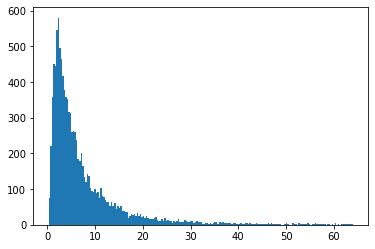

In [122]:
df_filter = df.sort_values(by=['price_1000_calories']).iloc[0:round(len(df)*0.95)]
hist = plt.hist(df_filter['price_1000_calories'], bins = 200)

In [131]:
# Export data to CSV
df_hist = pd.DataFrame()
df_hist['x_start'] = hist[1][0:len(hist[0])]
df_hist['x_end'] = hist[1][1:(len(hist[0])+1)]
df_hist['y'] = hist[0]
df_hist.to_csv(DIR_DATA_ANIMATIONS+'chart_histogram.csv', index=False)